In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import cv2
import os

import bin2cell as b2c

VisiumHD has the potential to be the most revolutionary technology in the field since droplet based single cell methods. Seeing how it's a fresh development, ways to maximise the utility of the data need to be proposed. Its 2um resolution is subcellular, and should in principle be useable for recreating cells more accurately than just going for the next resolution up (8um) and treating those as cells.

Bin2cell attempts to handle this problem. It starts by correcting for a novel technical effect in the data in variable bin dimensions, and then proposes a bin to cell assignment based on image segmentation. The result is an object with putative cells in it, ready for downstream analysis. The segmentation can be performed on both the H&E image and a visualisation of gene expression data, with certain caveats for both that will be discussed within the notebook.

The required inputs are the 2um bin output from the quantification pipeline, along with the high resolution H&E image that was used with it. The [10X demo mouse brain data](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-brain-he) has the 2um bin output [here](https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_square_002um_outputs.tar.gz) and the high resolution H&E image [here](https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_tissue_image.tif). Download both and extract them into the same directory as the notebook before proceeding.

In [2]:
path = "square_002um/"
source_image_path = "Visium_HD_Mouse_Brain_tissue_image.tif"

Loading the count matrix currently requires a bespoke loader function as 10X have moved the spot coordinates into a Parquet file. The required syntax changes have been [offered to Scanpy](https://github.com/scverse/scanpy/pull/2992) so hopefully just using Scanpy's default loader will be sufficient soon.

In [3]:
adata = b2c.read_visium(path, source_image_path = source_image_path)
adata.var_names_make_unique()
adata

anndata.py (1908): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1908): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Let's slightly filter the object - require the genes to show up in three spots, and require the spots to have any information at all (the data is extremely sparse at this stage).

In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 6132629 × 18823
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

Visium HD suffers from variable bin sizing. When printing the chips, the 2um bins can have about 10% variability in their width/height. Inspecting the total counts per spot reveals a characteristic striped appearance, with some rows/columns capturing visibly fewer transcripts than others.

To overcome this, `b2c.destripe()` identifies a user-specified quantile (by default 0.95) of total counts for each row, then divides the counts of the spots in that row by that value. This procedure is then repeated for the columns. `.obs["n_counts_adjusted"]` is obtained by multiplying the resulting per-spot factor by the global quantile of count totals, and the count matrix is rescaled to match it.

In [5]:
b2c.destripe(adata,quantile=0.99)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Prior to the adjustment, the count total has a visible striped appearance. The effect is diminished after the correction.

anndata.py (1301): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1301): Trying to modify attribute `.var` of view, initializing view as actual.


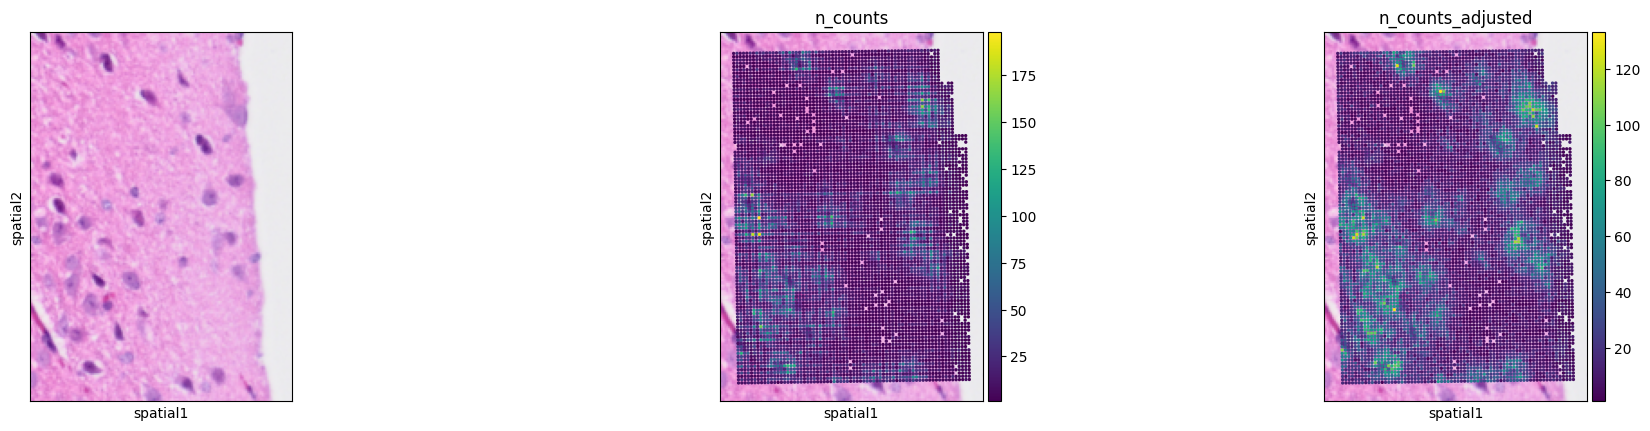

In [6]:
#define a mask to easily pull out this region of the object in the future
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 250) & 
        (adata.obs['array_col'] <= 450)
       )

bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"])

When performing segmentation, the resolution of the input images is controlled via the `mpp` parameter. This stands for microns per pixel and translates to how many micrometers are captured in each pixel of the input. If using the array coordinates (present as `.obs["array_row"]` and `.obs["array_col"]`) as an image, each of the pixels would have 2 micrometers in it, so the `mpp` would be 2.

In local testing, using an `mpp` of 0.5 has worked well with both GEX and H&E segmentation. When working with a tissue with small nuclei, the H&E `mpp` was lowered to 0.25 and the segmentation results improved. However, using excessively low values may yield adverse results as the segmentation models were trained on images of a certain resolution.

In [7]:
mpp = 0.5

We will first demonstrate GEX segmentation. Its main upside is that it is done independently of the H&E image, so in the event of a misalignment between the gene expression and tissue image the outcome will not be affected. However, the segmentation only performs well on sparse tissue, and struggles to differentiate individual cells in dense regions.

The input image is going to be a representation of the total counts per bin, with a Gaussian filter with a sigma of 5 applied for a little smoothing.

In [8]:
img = b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5)

os.makedirs("stardist", exist_ok=True)
cv2.imwrite("stardist/gex.tiff", img)

True

The segmentation is performed via StarDist's fluorescence model, and identifies cells. It is greatly recommended to lower the default probability threshold by specifying `prob_thresh` as part of the function call - the default model is quite a bit more stringent than we need.

The segmentation results are turned to a sparse matrix and efficiently stored in an `.npz` file. If desired, they can be read via `scipy.sparse.load_npz()`, and the sparse matrix's dimensions will match those of the input image.

In [9]:
b2c.stardist(image_path="stardist/gex.tiff", 
             labels_npz_path="stardist/gex.npz", 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=0.05, 
             nms_thresh=0.5
            )

2024-04-23 16:16:57.593305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 16:16:57.593367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 16:16:57.595624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 16:16:57.605459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 16:16:58.645550: W tensorflow/compiler/tf2

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 12/12 [06:22<00:00, 31.89s/it]


Found 49931 objects


We can now load the resulting cell calls into the object. For any given bin, its corresponding pixel in the segmented image will be located and any potential label transferred over. It's important to inform `b2c.insert_labels()` of whether the segmented image was based on array (GEX visualisation of the grid) or spatial (rescaled H&E image) coordinates, and what `mpp` was used.

In [10]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/gex.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

We can visualise the cells identified in the GEX space segmentation in our previously defined region.

3905597819.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
scatterplots.py (1234): The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


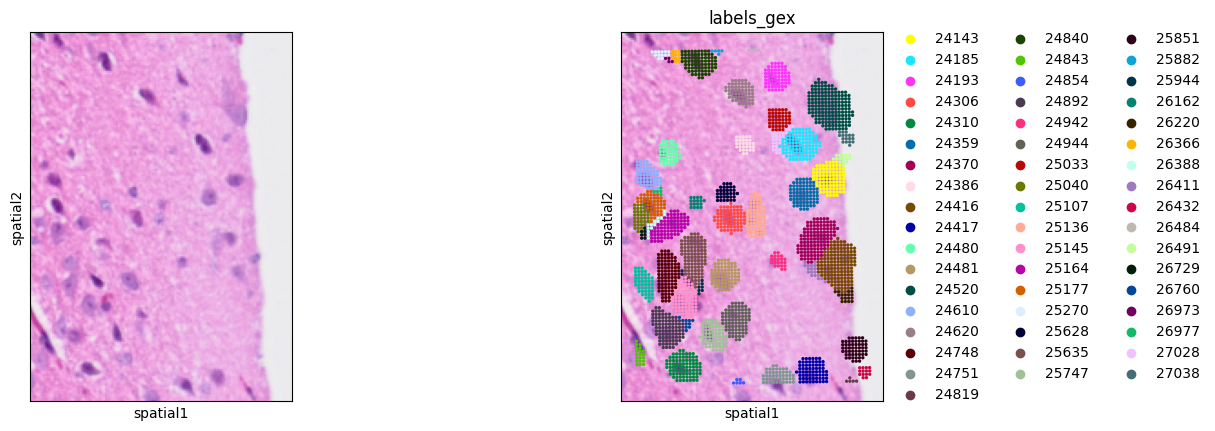

In [11]:
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"])

The other option for segmentation is using the H&E image. Its main advantage over using gene expression is that by going after nuclei, it fares well regardless of cell density and can successfully process a wider range of tissues.

However, it is important to ensure that the gene expression bin grid is well aligned with the H&E image, or the mismatch will have bins loading segmentation results for sections of the tissue they are quite distant from. Visualising the total expression across parts of the tissue, similar to the plot made to show the "striped" effect earlier, is likely to be helpful in assessing the situation. In the event of a misalignment, the alignment can be [corrected via 10X's loupe browser](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/inputs/visium-hd-loupe-alignment).

In [12]:
img = b2c.scaled_he_image(adata, mpp=mpp)

#cv2 expects BGR channel order, we're working with RGB
cv2.imwrite("stardist/he.tiff", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

The segmentation is done similarly, using StarDist's H&E model. Like previously, lowering the probability is greatly recommended.

In [13]:
b2c.stardist(image_path="stardist/he.tiff", 
             labels_npz_path="stardist/he.npz", 
             stardist_model="2D_versatile_he", 
             prob_thresh=0.01
            )

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 12/12 [03:20<00:00, 16.72s/it]


Found 62015 objects


Label insertion is performed analogously to the GEX example.

In [14]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/he.npz", 
                  basis="spatial", 
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

Let's visualise the nuclear H&E segmentation on our selected region.

3769521518.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
scatterplots.py (1234): The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


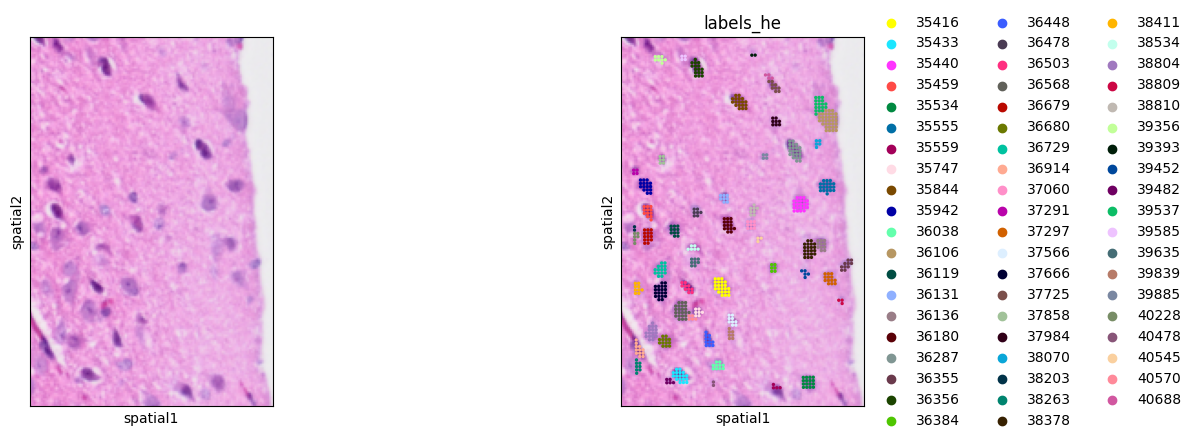

In [15]:
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"])

The package comes with a utility function to visualise StarDist segmentation on a fragment of the input image. As we can see, the calls are faithfully captured in the bins.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


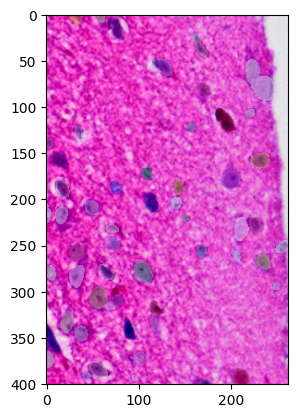

In [16]:
#PIL crop is defined as a tuple of (left, upper, right, lower) coordinates
#spatial[:,0] is left-right and spatial[:,1] is up-down
#need to scale it to the appropriate mpp first, use a scale factor for it
scalef = b2c.mpp_to_scalef(adata, mpp=mpp)
spatial_mins = np.floor(np.min(bdata.obsm['spatial'], axis=0)*scalef).astype(int)
spatial_maxes = np.ceil(np.max(bdata.obsm['spatial'], axis=0)*scalef).astype(int)
crop = tuple(np.hstack((spatial_mins, spatial_maxes)))

rendered = b2c.view_stardist_labels(image_path="stardist/he.tiff", 
                                    labels_npz_path="stardist/he.npz", 
                                    crop=crop)
plt.imshow(rendered)

However, StarDist's H&E segmentation merely identifies nuclei, while there's more to a cell than just the nucleus. `b2c.expand_labels()` finds bins up to `max_bin_distance` (by default 4) bins away from a labelled nucleus, and joins them into the corresponding cell. In the event of a bin being equidistant from two nuclei, it's assigned to one based on the similarity of their gene expression profiles.

In [17]:
b2c.expand_labels(adata, 
                  labels_key='labels_he', 
                  expanded_labels_key="labels_he_expanded", 
                  max_bin_distance=2
                 )

anndata.py (522): The dtype argument is deprecated and will be removed in late 2024.


The expanded labels capture more bins.

3737439708.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
scatterplots.py (1234): The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


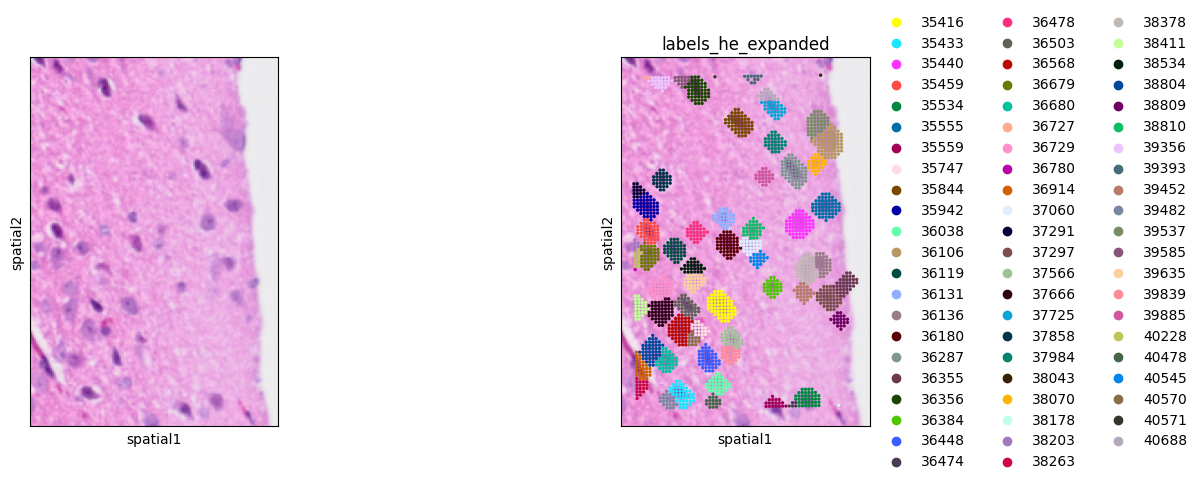

In [18]:
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he_expanded"])

At this point, the counts have been destriped and bins have been assigned to cells based on nuclei segmentation and subsequent label expansion. Time to group the bins into cells!

In [19]:
cdata = b2c.bin_to_cell(adata, labels_key="labels_he_expanded")

The object features the sum of gene expression of the constituent bins, and means of the array and spatial coordinates to represent the cell centroids. Let's visualise our test fragment of the tissue, now in cell space!

anndata.py (1301): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1301): Trying to modify attribute `.var` of view, initializing view as actual.


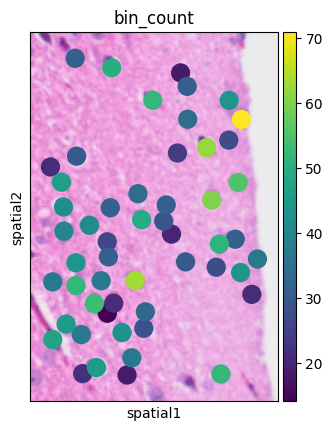

In [20]:
cell_mask = ((cdata.obs['array_row'] >= 1450) & 
             (cdata.obs['array_row'] <= 1550) & 
             (cdata.obs['array_col'] >= 250) & 
             (cdata.obs['array_col'] <= 450)
            )

ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color="bin_count")

At this point the object is ready for further analysis. As destriping provides non-integer values, if integers are strictly necessary for a downstream application just round the count matrix.